In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/AAP.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,73.489998,73.760002,71.690002,72.489998,71.357033,800500
1,1/3/2013,72.849998,73.440002,72.129997,72.489998,71.357033,520600
2,1/4/2013,72.750000,73.639999,72.389999,73.620003,72.469398,615000
3,1/7/2013,73.150002,73.800003,73.150002,73.370003,72.223305,1054400
4,1/8/2013,73.169998,73.660004,72.139999,72.169998,71.042053,840000


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: 7651.069901.3, cost: -2895.605713, total money: 760.629899
epoch: 20, total rewards: 4953.039956.3, cost: -4957.387695, total money: 875.769952
epoch: 30, total rewards: 2306.749856.3, cost: -8133.884766, total money: 1016.649881
epoch: 40, total rewards: 341.609933.3, cost: -21015.916016, total money: 6639.649926
epoch: 50, total rewards: 629.069916.3, cost: -21141.320312, total money: 7414.969910
epoch: 60, total rewards: -26.699981.3, cost: -24747.191406, total money: 9973.300019
epoch: 70, total rewards: -342.420029.3, cost: -25176.697266, total money: 6773.779969
epoch: 80, total rewards: 29.899994.3, cost: -22526.849609, total money: 5180.009964
epoch: 90, total rewards: -235.420006.3, cost: -27062.205078, total money: 7818.799980
epoch: 100, total rewards: -511.340050.3, cost: -21362.251953, total money: 5512.949943
epoch: 110, total rewards: -734.250092.3, cost: -23114.759766, total money: 5261.949905
epoch: 120, total rewards: -667.360016.3, cost: -24

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 4: buy 1 unit at price 72.169998, total balance 9927.830002
day 5, sell 1 unit at price 72.389999, investment 0.304838 %, total balance 10000.220001,
day 9: buy 1 unit at price 73.639999, total balance 9926.580002
day 12, sell 1 unit at price 73.750000, investment 0.149376 %, total balance 10000.330002,
day 21: buy 1 unit at price 73.660004, total balance 9926.669998
day 22: buy 1 unit at price 72.230003, total balance 9854.439995
day 25: buy 1 unit at price 77.139999, total balance 9777.299995
day 26, sell 1 unit at price 78.900002, investment 7.113763 %, total balance 9856.199997,
day 27: buy 1 unit at price 78.389999, total balance 9777.809998
day 28, sell 1 unit at price 78.599998, investment 8.819043 %, total balance 9856.409996,
day 29, sell 1 unit at price 78.970001, investment 2.372312 %, total balance 9935.379997,
day 30: buy 1 unit at price 78.839996, total balance 9856.540001
day 31: buy 1 unit at price 79.000000, total balance 9777.540001
day 32: buy 1 unit at price 80.

day 192: buy 1 unit at price 81.980003, total balance 9912.800041
day 193: buy 1 unit at price 81.250000, total balance 9831.550041
day 195: buy 1 unit at price 81.760002, total balance 9749.790039
day 199: buy 1 unit at price 96.160004, total balance 9653.630035
day 200: buy 1 unit at price 97.220001, total balance 9556.410034
day 201: buy 1 unit at price 98.699997, total balance 9457.710037
day 202: buy 1 unit at price 98.449997, total balance 9359.260040
day 204, sell 1 unit at price 99.769997, investment 21.700406 %, total balance 9459.030037,
day 205: buy 1 unit at price 99.419998, total balance 9359.610039
day 206: buy 1 unit at price 102.669998, total balance 9256.940041
day 207: buy 1 unit at price 101.000000, total balance 9155.940041
day 208, sell 1 unit at price 100.300003, investment 23.446158 %, total balance 9256.240044,
day 209: buy 1 unit at price 100.000000, total balance 9156.240044
day 210: buy 1 unit at price 99.180000, total balance 9057.060043
day 213: buy 1 unit 

day 364, sell 1 unit at price 124.800003, investment 2.202934 %, total balance 9803.130028,
day 367: buy 1 unit at price 129.720001, total balance 9673.410026
day 369, sell 1 unit at price 129.800003, investment 5.959186 %, total balance 9803.210030,
day 370, sell 1 unit at price 130.669998, investment 7.600458 %, total balance 9933.880028,
day 371: buy 1 unit at price 131.660004, total balance 9802.220024
day 372: buy 1 unit at price 129.850006, total balance 9672.370018
day 374: buy 1 unit at price 133.479996, total balance 9538.890022
day 375, sell 1 unit at price 134.919998, investment 5.645603 %, total balance 9673.810020,
day 377: buy 1 unit at price 134.250000, total balance 9539.560020
day 378: buy 1 unit at price 134.940002, total balance 9404.620018
day 380, sell 1 unit at price 132.270004, investment 4.174217 %, total balance 9536.890022,
day 381, sell 1 unit at price 133.580002, investment 2.975640 %, total balance 9670.470024,
day 382: buy 1 unit at price 133.160004, total

day 634, sell 1 unit at price 164.110001, investment 12.829154 %, total balance 6783.339989,
day 636, sell 1 unit at price 167.210007, investment 16.126120 %, total balance 6950.549996,
day 638, sell 1 unit at price 169.360001, investment 13.012145 %, total balance 7119.909996,
day 639: buy 1 unit at price 169.699997, total balance 6950.209999
day 640: buy 1 unit at price 168.690002, total balance 6781.519997
day 641: buy 1 unit at price 167.529999, total balance 6613.989998
day 642: buy 1 unit at price 168.220001, total balance 6445.769997
day 643: buy 1 unit at price 168.389999, total balance 6277.379998
day 646: buy 1 unit at price 170.300003, total balance 6107.079994
day 647, sell 1 unit at price 173.059998, investment 13.945215 %, total balance 6280.139992,
day 648, sell 1 unit at price 172.539993, investment 12.815477 %, total balance 6452.679985,
day 654: buy 1 unit at price 173.750000, total balance 6278.929985
day 655: buy 1 unit at price 173.660004, total balance 6105.269982

day 807, sell 1 unit at price 157.940002, investment -21.179759 %, total balance 6173.349922,
day 808: buy 1 unit at price 157.470001, total balance 6015.879921
day 809, sell 1 unit at price 158.610001, investment -3.662536 %, total balance 6174.489922,
day 811, sell 1 unit at price 161.089996, investment -1.905983 %, total balance 6335.579918,
day 812: buy 1 unit at price 161.820007, total balance 6173.759911
day 814, sell 1 unit at price 163.029999, investment 0.128972 %, total balance 6336.789910,
day 815: buy 1 unit at price 163.789993, total balance 6172.999916
day 816, sell 1 unit at price 160.339996, investment -1.746434 %, total balance 6333.339913,
day 817: buy 1 unit at price 160.419998, total balance 6172.919914
day 818, sell 1 unit at price 159.229996, investment -3.403301 %, total balance 6332.149910,
day 819, sell 1 unit at price 160.470001, investment 3.676187 %, total balance 6492.619911,
day 821, sell 1 unit at price 155.830002, investment 0.000000 %, total balance 664

day 959, sell 1 unit at price 141.929993, investment -14.756761 %, total balance 7585.579933,
day 960: buy 1 unit at price 141.100006, total balance 7444.479927
day 962: buy 1 unit at price 143.960007, total balance 7300.519921
day 963: buy 1 unit at price 139.220001, total balance 7161.299919
day 964: buy 1 unit at price 140.199997, total balance 7021.099922
day 965, sell 1 unit at price 140.080002, investment -15.943590 %, total balance 7161.179924,
day 966, sell 1 unit at price 139.789993, investment -11.547710 %, total balance 7300.969918,
day 967: buy 1 unit at price 138.139999, total balance 7162.829918
day 969: buy 1 unit at price 136.190002, total balance 7026.639916
day 973, sell 1 unit at price 145.820007, investment -7.982580 %, total balance 7172.459923,
day 974: buy 1 unit at price 145.020004, total balance 7027.439919
day 975, sell 1 unit at price 142.899994, investment -9.522609 %, total balance 7170.339913,
day 976: buy 1 unit at price 164.330002, total balance 7006.009

day 1131: buy 1 unit at price 116.050003, total balance 5850.499932
day 1132: buy 1 unit at price 116.589996, total balance 5733.909935
day 1133: buy 1 unit at price 118.410004, total balance 5615.499932
day 1134, sell 1 unit at price 105.209999, investment -30.222841 %, total balance 5720.709931,
day 1137: buy 1 unit at price 101.169998, total balance 5619.539933
day 1138: buy 1 unit at price 100.250000, total balance 5519.289933
day 1139: buy 1 unit at price 100.940002, total balance 5418.349930
day 1140, sell 1 unit at price 103.220001, investment -30.425990 %, total balance 5521.569931,
day 1143: buy 1 unit at price 100.300003, total balance 5421.269928
day 1144, sell 1 unit at price 100.870003, investment -30.673538 %, total balance 5522.139931,
day 1145: buy 1 unit at price 103.230003, total balance 5418.909928
day 1146, sell 1 unit at price 105.269997, investment -26.250531 %, total balance 5524.179924,
day 1147: buy 1 unit at price 103.169998, total balance 5421.009926
day 1148

day 1312: buy 1 unit at price 114.250000, total balance 7183.059914
day 1314: buy 1 unit at price 111.709999, total balance 7071.349915
day 1315, sell 1 unit at price 110.839996, investment 7.915488 %, total balance 7182.189911,
day 1316: buy 1 unit at price 114.769997, total balance 7067.419915
day 1317, sell 1 unit at price 115.010002, investment 14.380904 %, total balance 7182.429917,
day 1318, sell 1 unit at price 115.980003, investment 16.317325 %, total balance 7298.409920,
day 1319: buy 1 unit at price 118.550003, total balance 7179.859917
day 1320: buy 1 unit at price 111.930000, total balance 7067.929917
day 1321: buy 1 unit at price 111.910004, total balance 6956.019913
day 1322: buy 1 unit at price 114.480003, total balance 6841.539910
day 1323: buy 1 unit at price 116.389999, total balance 6725.149910
day 1324, sell 1 unit at price 111.910004, investment 4.539935 %, total balance 6837.059914,
day 1326: buy 1 unit at price 112.139999, total balance 6724.919915
day 1327, sell

day 1478: buy 1 unit at price 184.720001, total balance 6179.559906
day 1479, sell 1 unit at price 177.679993, investment 26.300826 %, total balance 6357.239899,
day 1482, sell 1 unit at price 177.750000, investment 24.075113 %, total balance 6534.989899,
day 1485: buy 1 unit at price 177.240005, total balance 6357.749894
day 1486: buy 1 unit at price 177.720001, total balance 6180.029892
day 1487: buy 1 unit at price 179.270004, total balance 6000.759888
day 1488: buy 1 unit at price 178.949997, total balance 5821.809891
day 1489: buy 1 unit at price 177.669998, total balance 5644.139893
day 1490: buy 1 unit at price 177.710007, total balance 5466.429886
day 1491: buy 1 unit at price 177.889999, total balance 5288.539887
day 1493, sell 1 unit at price 175.759995, investment 21.130246 %, total balance 5464.299881,
day 1494: buy 1 unit at price 167.589996, total balance 5296.709885
day 1496, sell 1 unit at price 165.800003, investment 13.290055 %, total balance 5462.509888,
day 1497, se

day 1645: buy 1 unit at price 157.669998, total balance 6610.039887
day 1646, sell 1 unit at price 157.899994, investment -12.743154 %, total balance 6767.939881,
day 1647: buy 1 unit at price 156.929993, total balance 6611.009888
day 1649, sell 1 unit at price 157.639999, investment -10.842146 %, total balance 6768.649887,
day 1650, sell 1 unit at price 158.500000, investment -8.099960 %, total balance 6927.149887,
day 1652, sell 1 unit at price 152.619995, investment -8.237140 %, total balance 7079.769883,
day 1653: buy 1 unit at price 153.039993, total balance 6926.729889
day 1654: buy 1 unit at price 151.800003, total balance 6774.929886
day 1655, sell 1 unit at price 150.639999, investment -5.785227 %, total balance 6925.569886,
day 1656, sell 1 unit at price 149.949997, investment -5.166961 %, total balance 7075.519882,
day 1657, sell 1 unit at price 145.779999, investment -6.172361 %, total balance 7221.299881,
day 1658: buy 1 unit at price 143.160004, total balance 7078.139878


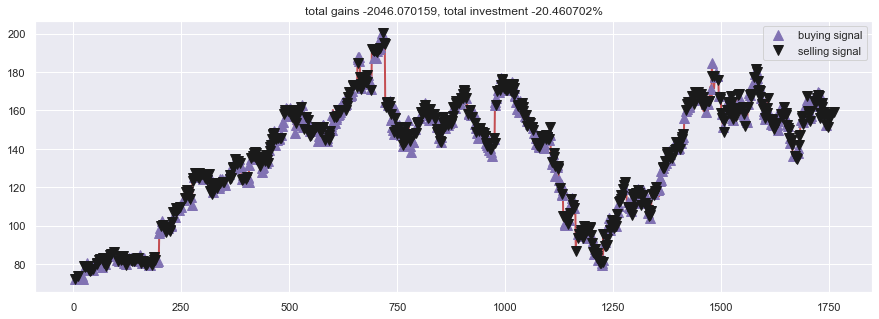

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()